[View in Colaboratory](https://colab.research.google.com/github/sohamshashank1/MLtoolkit/blob/master/TF_Exercise_Text.ipynb)

***BAG OF WORDS***

***The objective here is to check results with BOW approach also, check how multiple NN results vary from logistic regression on the same text ***

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Start a graph session
sess = tf.Session()

# Check if data was downloaded, otherwise download it and save for future use
save_file_name = os.path.join('temp','temp_spam_data.csv')

# Create directory if it doesn't exist
if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # And write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

# Relabel 'spam' as 1, 'ham' as 0
target = [1 if x == 'spam' else 0 for x in target]
texts = [x.lower() for x in texts]

# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

sentence_size = 25
min_word_freq = 3

# Setup vocabulary processor
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)

# Have to fit transform to get length of unique words.
vocab_processor.transform(texts)
transformed_texts = np.array([x for x in vocab_processor.transform(texts)])
embedding_size = len(np.unique(transformed_texts))

# Split up data set into train/test
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

# Setup Index Matrix for one-hot-encoding
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)

# Text-Vocab Embedding
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

# Declare model operations
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Prediction operation
prediction = tf.sigmoid(model_output)

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

# Start Logistic Regression
print('Starting Training Over {} Sentences.'.format(len(texts_train)))
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    # Run through each observation for training
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix + 1) % 10 == 0:
        print('Training Observation #{}, Loss = {}'.format(ix+1, temp_loss))
        
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))



**TFIDF using SINGLE NN layers **

Generation # 500. Train Loss (Test Loss): 0.79 (0.72). Train Acc (Test Acc): 0.50 (0.58)
Generation # 1000. Train Loss (Test Loss): 0.59 (0.62). Train Acc (Test Acc): 0.68 (0.67)
Generation # 1500. Train Loss (Test Loss): 0.62 (0.56). Train Acc (Test Acc): 0.67 (0.73)
Generation # 2000. Train Loss (Test Loss): 0.55 (0.52). Train Acc (Test Acc): 0.75 (0.77)
Generation # 2500. Train Loss (Test Loss): 0.61 (0.50). Train Acc (Test Acc): 0.74 (0.80)
Generation # 3000. Train Loss (Test Loss): 0.60 (0.48). Train Acc (Test Acc): 0.76 (0.81)
Generation # 3500. Train Loss (Test Loss): 0.41 (0.46). Train Acc (Test Acc): 0.86 (0.82)
Generation # 4000. Train Loss (Test Loss): 0.48 (0.46). Train Acc (Test Acc): 0.84 (0.83)
Generation # 4500. Train Loss (Test Loss): 0.42 (0.45). Train Acc (Test Acc): 0.82 (0.84)
Generation # 5000. Train Loss (Test Loss): 0.52 (0.45). Train Acc (Test Acc): 0.81 (0.85)
Generation # 5500. Train Loss (Test Loss): 0.46 (0.44). Train Acc (Test Acc): 0.83 (0.85)
Generation 

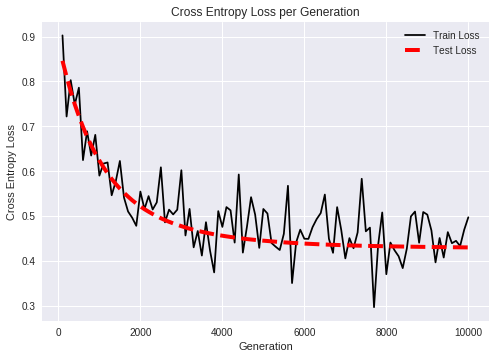

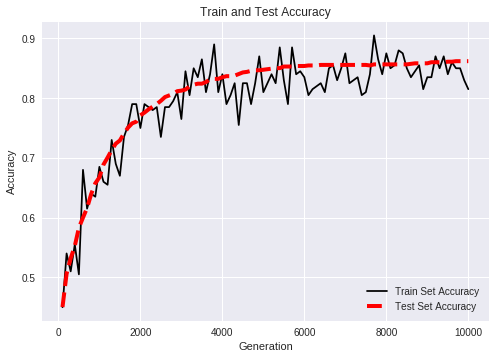

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Start a graph session
sess = tf.Session()

batch_size = 200
max_features = 1000


# Check if data was downloaded, otherwise download it and save for future use
save_file_name = 'temp_spam_data.csv'
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x) >= 1]
    
    # And write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)


texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

# Relabel 'spam' as 1, 'ham' as 0
target = [1. if x == 'spam' else 0. for x in target]

# Normalize text
# Lower case
texts = [x.lower() for x in texts]

# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]


# Define tokenizer
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# Create TF-IDF of texts
tfidf = TfidfVectorizer(tokenizer=None, stop_words='english', max_features=max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)

# Split up data set into train/test
train_indices = np.random.choice(sparse_tfidf_texts.shape[0], round(0.8*sparse_tfidf_texts.shape[0]), replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# # Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[max_features, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)



# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(x_data, A), b)

# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

# Start Logistic Regression
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # Only record loss and accuracy every 100 generations
    if (i + 1) % 100 == 0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    if (i + 1) % 500 == 0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))


# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

**TFIDF on multiple layers using TF **

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Generation # 500. Train Loss (Test Loss): 0.15 (0.13). Train Acc (Test Acc): 0.85 (0.87)
Generation # 1000. Train Loss (Test Loss): 0.18 (0.13). Train Acc (Test Acc): 0.82 (0.87)
Generation # 1500. Train Loss (Test Loss): 0.12 (0.13). Train Acc (Test Acc): 0.88 (0.87)
Generation # 2000. Train Loss (Test Loss): 0.16 (0.13). Train Acc (Test Acc): 0.84 (0.87)
Generation # 2500. Train Loss (Test Loss): 0.14 (0.13). Train Acc (Test Acc): 0.86 (0.87)
Generation # 3000. Train Loss (Test Loss): 0.12 (0.13). Train Acc (Test Acc): 0.88 (0.87)
Generation # 3500. Train Loss (Test Loss): 0.16 (0.13). Train Acc (Test Acc): 0.84 (0.87)
Generation # 4000. Train Loss (Test Loss): 0.14 (0.13). Train Acc (Test Acc): 0.86 (0.87)
Generation # 4500. Train Loss (Test Loss): 0.10 (0.13). Train Acc (Test Acc): 0.90 (0.87)
Generation # 5000. Train Loss (Test Loss): 0.16 (0.13). Train Acc (Test Acc): 0.84 (0.87)
Generation # 5500. Train Lo

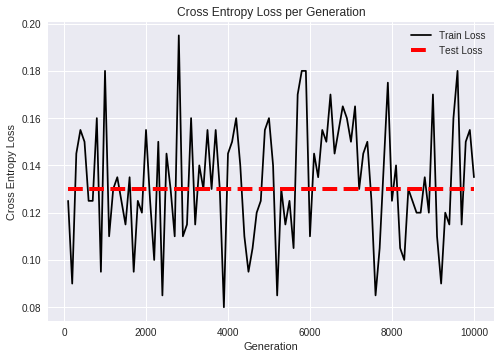

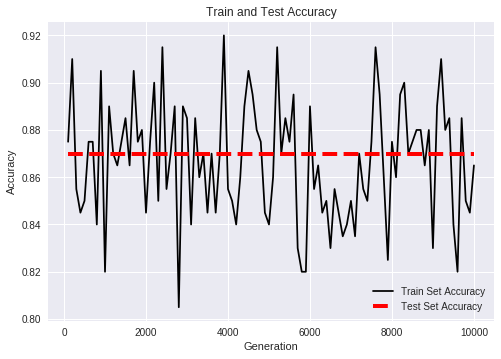

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Start a graph session
sess = tf.Session()

batch_size = 200
max_features = 1000


# Check if data was downloaded, otherwise download it and save for future use
save_file_name = 'temp_spam_data.csv'
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x) >= 1]
    
    # And write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)


texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

# Relabel 'spam' as 1, 'ham' as 0
target = [1. if x == 'spam' else 0. for x in target]

# Normalize text
# Lower case
texts = [x.lower() for x in texts]

# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]


# Define tokenizer
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# Create TF-IDF of texts
tfidf = TfidfVectorizer(tokenizer=None, stop_words='english', max_features=max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)

# Split up data set into train/test
train_indices = np.random.choice(sparse_tfidf_texts.shape[0], round(0.8*sparse_tfidf_texts.shape[0]), replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# # Create variables for logistic regression
# A = tf.Variable(tf.random_normal(shape=[max_features, 1]))
# b = tf.Variable(tf.random_normal(shape=[1, 1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)




def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return weight
def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return bias
def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return tf.nn.relu(layer)

# -------Create the first layer (50 hidden nodes)--------
weight_1 = init_weight(shape=[max_features, 400], st_dev=10.0)
bias_1 = init_bias(shape=[400], st_dev=10.0)
layer_1 = fully_connected(x_data, weight_1, bias_1)

# -------Create second layer (25 hidden nodes)--------
weight_2 = init_weight(shape=[400, 250], st_dev=10.0)
bias_2 = init_bias(shape=[250], st_dev=10.0)
layer_2 = fully_connected(layer_1, weight_2, bias_2)


# -------Create third layer (5 hidden nodes)--------
weight_3 = init_weight(shape=[250, 50], st_dev=10.0)
bias_3 = init_bias(shape=[50], st_dev=10.0)
layer_3 = fully_connected(layer_2, weight_3, bias_3)


# -------Create output layer (1 output value)--------
weight_4 = init_weight(shape=[50, 1], st_dev=10.0)
bias_4 = init_bias(shape=[1], st_dev=10.0)
final_output = fully_connected(layer_3, weight_4, bias_4)
###############  

loss = tf.reduce_mean(tf.abs(y_target - final_output))
my_opt = tf.train.AdamOptimizer(0.05)
train_step = my_opt.minimize(loss)
init = tf.initialize_all_variables()
sess.run(init)





# Declare logistic model (sigmoid in loss function)
# model_output = tf.add(tf.matmul(x_data, A), b)




# Declare loss function (Cross Entropy loss)
##########loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Actual Prediction
# prediction = tf.round(tf.sigmoid(model_output))

##########
prediction = tf.round(tf.sigmoid(final_output))


predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Declare optimizer
##############
# my_opt = tf.train.GradientDescentOptimizer(0.0025)
# train_step = my_opt.minimize(loss)
###############
# Intitialize Variables
# init = tf.global_variables_initializer()
# sess.run(init)

# Start Logistic Regression
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # Only record loss and accuracy every 100 generations
    if (i + 1) % 100 == 0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    if (i + 1) % 500 == 0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))


# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
